# Tutorial: data integration for simulated data

## load package

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [4]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [5]:
data_path = "/home/nas2/biod/yangchenghui/my_ych_project_simulation1/feature_selected_simulated1_data/"
batch1 = pd.read_csv(data_path+"Batch1_feature50_selected_data.txt", sep='\t',index_col=0)
batch2 = pd.read_csv(data_path+"Batch2_feature50_selected_data.txt", sep='\t',index_col=0)

cell1_cluster = pd.read_csv(data_path+"simulation1_label1.txt", sep='\t').rename(columns={'x': 'cluster'})
cell2_cluster = pd.read_csv(data_path+"simulation1_label2.txt", sep='\t').rename(columns={'x': 'cluster'})
cell1_cluster.insert(0, 'cell', list(batch1.columns))
cell2_cluster.insert(0, 'cell', list(batch2.columns))
cell1_cluster = cell1_cluster.reset_index(drop=True)
cell2_cluster = cell2_cluster.reset_index(drop=True)

In [6]:
X1 = batch1.T
X2 = batch2.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = [str(i) for i in cell1_cluster['cluster']]
basic_labels2 = [str(i) for i in cell2_cluster['cluster']]
print("Dimensions of basic_labels are: ", "basic_labels1 = ", len(basic_labels1), " basic_labels2 = ", len(basic_labels2))
cell_names1 = list(batch1.columns)
cell_names2 = list(batch2.columns)
gene_names1 =list(batch1.index)
gene_names2 =list(batch2.index)

Dimensions of input datasets are:  X1 =  (1000, 82)  X2 =  (1200, 82)
Dimensions of basic_labels are:  basic_labels1 =  1000  basic_labels2 =  1200


## build a priori feature graph

In [7]:
markers1 = pd.read_csv(data_path+"Batch1_marker_genes.txt", sep='\t',index_col=0)
markers2 = pd.read_csv(data_path+"Batch2_marker_genes.txt", sep='\t',index_col=0)
group_affinity = pre.calculate_group_affinity(markers1,markers2)
match_cluster = pd.DataFrame(group_affinity.idxmax(axis=1),columns=['Batch2'])
match_cluster

/home/nas2/biod/yangchenghui/FGOT-master/FGOT/preprocess.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7622641509433963' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group_affinity.loc[group_i,group_j] = jaccard_index(batch1_label2marker[group_i],batch2_label2marker[group_j])
/home/nas2/biod/yangchenghui/FGOT-master/FGOT/preprocess.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8007312614259597' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group_affinity.loc[group_i,group_j] = jaccard_index(batch1_label2marker[group_i],batch2_label2marker[group_j])


,Batch2
Group2,Group2
Group1,Group1


In [8]:
feature_matrix = pd.DataFrame(np.inf, index=gene_names1, columns=gene_names2)
for gene1 in feature_matrix.index:
    for gene2 in feature_matrix.columns:
        group1 = markers1[markers1['gene']==gene1].cluster.tolist()
        group2 = markers2[markers2['gene']==gene2].cluster.tolist()
        for i in group1:
            if i not in group2:
                continue
            for j in group2:
                if match_cluster.loc[i].Batch2 == j:
                    feature_matrix.loc[gene1,gene2] = 1

In [9]:
feature_matrix.shape

(82, 82)

## Compute cost
Calculate the similarity between cells through MNN pairs.

In [10]:
S_m = pre.calculate_cell_similarity_byMNN(X1,X2,cell_names1,cell_names2,scale=1,knn = 50)
S_m

the number of MNN pairs is  18690


,Cell1001-1,Cell1002-1,Cell1003-1,Cell1004-1,Cell1005-1,Cell1006-1,Cell1007-1,Cell1008-1,Cell1009-1,Cell1010-1,...,Cell2191-1,Cell2192-1,Cell2193-1,Cell2194-1,Cell2195-1,Cell2196-1,Cell2197-1,Cell2198-1,Cell2199-1,Cell2200-1
Cell1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell997,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
S_sm = pre.smooth_cell_similarity_byLaplacian1(S_m,X1,X2)
S = S_sm/np.max(S_sm) + S_m/np.max(S_m)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# compute cost
cost = np.array(np.exp(np.max(S) - S))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

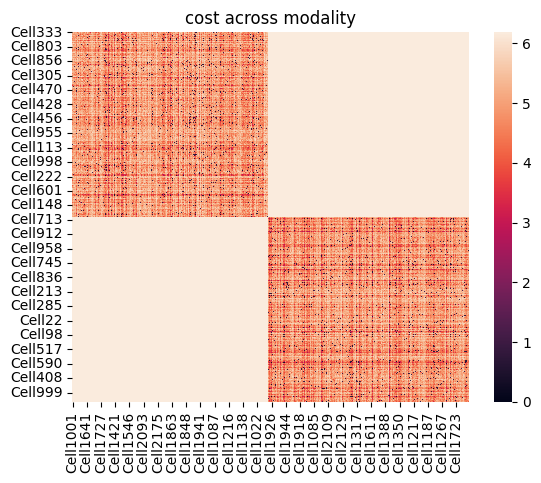

In [14]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [15]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=gene_names1)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names2)

## solve the feature-guided optimal transport problem

In [16]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost,\
    cell1_cluster, cell2_cluster, minibatch=1, batchsize=500, device='cuda:9', eps_p = 1e-2)

minibatch = 1 and device =  cuda:9
the total number of computing batch is  4


100%|██████████| 4/4 [34:29<00:00, 517.42s/it]


## make multi-omics alignment from the transport tensor

In [17]:
P = fgot_tol(P_tensor)
P.shape

  0%|          | 0/3362 [00:00<?, ?it/s]

100%|██████████| 3362/3362 [00:31<00:00, 106.07it/s]


(1000, 1200)

Text(0.5, 1.0, 'optimal transport matrix')

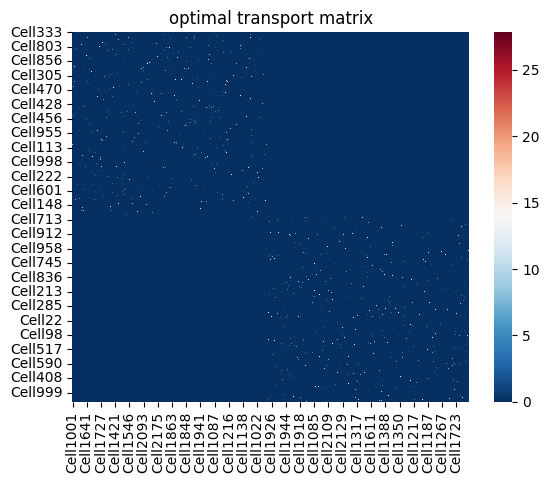

In [18]:
P_df = pd.DataFrame(P, index = cell_names1, columns = cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_P = P_df.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_P = sorted_P.iloc[:, sorted_rows]
sns.heatmap(sorted_P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [19]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

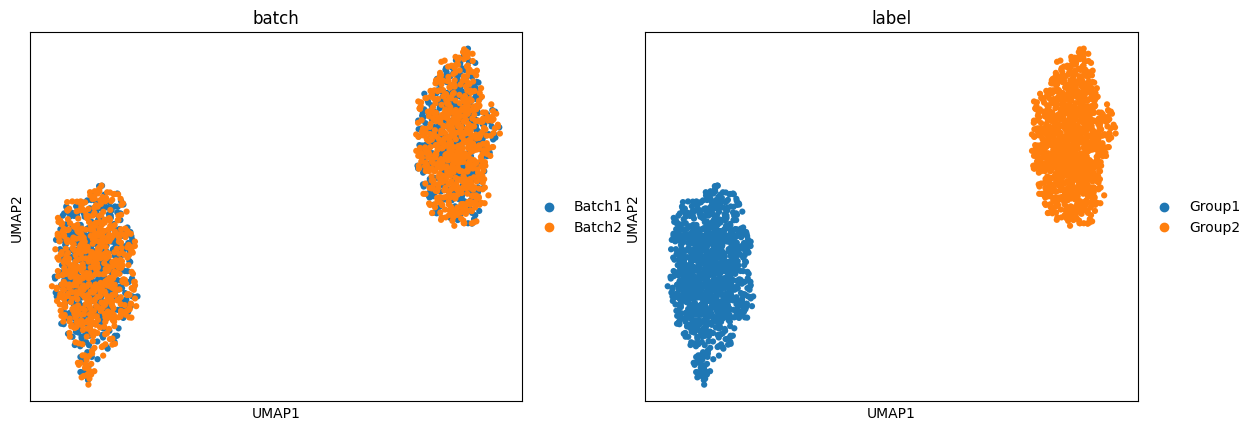

In [20]:
data_aligned = np.concatenate((X1_aligned,X2_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['Batch1'] * n1 + ['Batch2'] * n2)
adata_aligned.obs['label'] = np.concatenate((basic_labels1,basic_labels2), axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80)